# COVID-19 in India: What Went So Terribly Wrong?

## Motivation

Recently, India has experienced an increase in COVID-19 cases and deaths. With insufficient medical resources and poor living conditions, many people have to unfortunately be turned away from hospitals in favor of people with more severe cases. But until now, it seemed as if India was doing well with the pandemic! So what has happened recently to change that? In this notebook we will explore that question and investigate which locations within India have it the worst and need medical resources the most.

## Data Source

https://github.com/datameet/covid19

This data combines multiple data sources from Indian government websites into a cleaner and more accesible format. The government sources for COVID-19 data are the Ministry of Health & Family Welfare and The Indian Council of Medical Research, or ICMR.

In [110]:
import requests
import json
import pandas as pd

Because the data is stored in a specific JSON format, we need to read the JSON file from the web and read it into a JSON data structure.

In [125]:
# Takes a JSON file from the data source and places its contents inside a dictionary
def get_json(json_file):
    link = 'https://raw.githubusercontent.com/datameet/covid19/master/data/' + json_file
    r = requests.get(link)
    data = r.json()

    # takes the data from link and saves it in a JSON file
    with open(json_file, 'w') as f:
        json.dump(data, f)

    # takes the JSON file and places the contents in a dictionary
    with open(json_file) as f:
        data = json.load(f)

    return data

In [127]:
get_json('all_totals.json')

', 'death'], 'value': 20160},
  {'key': ['2020-07-07T08:00:00.00+05:30', 'total_confirmed_cases'],
   'value': 719665},
  {'key': ['2020-07-08T08:00:00.00+05:30', 'active_cases'], 'value': 264944},
  {'key': ['2020-07-08T08:00:00.00+05:30', 'cured'], 'value': 456831},
  {'key': ['2020-07-08T08:00:00.00+05:30', 'death'], 'value': 20642},
  {'key': ['2020-07-08T08:00:00.00+05:30', 'total_confirmed_cases'],
   'value': 742417},
  {'key': ['2020-07-09T08:00:00.00+05:30', 'active_cases'], 'value': 269789},
  {'key': ['2020-07-09T08:00:00.00+05:30', 'cured'], 'value': 476378},
  {'key': ['2020-07-09T08:00:00.00+05:30', 'death'], 'value': 21129},
  {'key': ['2020-07-09T08:00:00.00+05:30', 'total_confirmed_cases'],
   'value': 767296},
  {'key': ['2020-07-10T08:00:00.00+05:30', 'active_cases'], 'value': 276685},
  {'key': ['2020-07-10T08:00:00.00+05:30', 'cured'], 'value': 495513},
  {'key': ['2020-07-10T08:00:00.00+05:30', 'death'], 'value': 21604},
  {'key': ['2020-07-10T08:00:00.00+05:30', 

As you can see, the data is stored in a key-value pair format, where the key contains the timestamp and attribute name, while the value contains the number associated with that attribute. We can wrangle this data format into a more table-like structure so that we can convert this JSON file into a dataframe.

In [128]:
# Takes input from the JSON dictionary and converts it into
# a new dictionary with a different format. The attributes
# found in the input ("cases", "deaths", etc.) are keys in the
# new dictionary, and the values are a single key-value pair
# of time and the value corresponding to the attribute.
def extract_data(data):
    extracted_data = {}
    rows = data["rows"]

    for row in rows:
        time, attribute, value = extract_row(row)

        if attribute not in extracted_data:
            extracted_data[attribute] = {time : value}
        else:
            extracted_data[attribute][time] = value

    return extracted_data

# Extracts the time, attribute, and value information
# from one row of the JSON dictionary. Used as a helper
# function in extract_data()
def extract_row(row):
    time = row['key'][0]
    attribute = row['key'][1]
    value = row['value']

    return time[:10], attribute, value

In [129]:
data_dict = extract_data(data)
df = pd.DataFrame(data_dict)
df

,active_cases,cured,death,total_confirmed_cases
2020-01-30,1,0,0,1
2020-02-02,2,0,0,2
2020-02-03,3,0,0,3
2020-03-02,5,0,0,5
2020-03-03,6,0,0,6
...,...,...,...,...
2021-05-07,3645164,17612351,234083,21491598
2021-05-08,3723446,17930960,238270,21892676
2021-05-09,3736648,18317404,242362,22296414
2021-05-10,3745237,18671222,246116,22662575


There is a problem here with the date ranges, and that is that they are not continuous! If we ever want to visualize the data, it will be important to have a continuous date range. We can do this by adding new rows for the missing days, and simply taking the previous row's values as the values for the new rows. We fill in the missing values in this way because all of the metrics in the dataset are cumulative.

In [130]:
# calculate date range index using lowest and highest dates
idx = pd.date_range(df.index.min(), df.index.max())
df.index = pd.DatetimeIndex(df.index)

# reindex the data using date range, and fill any missing dates
# with the previous date's row values
df = df.reindex(index=idx, method='ffill')

df

,active_cases,cured,death,total_confirmed_cases
2020-01-30,1,0,0,1
2020-01-31,1,0,0,1
2020-02-01,1,0,0,1
2020-02-02,2,0,0,2
2020-02-03,3,0,0,3
...,...,...,...,...
2021-05-07,3645164,17612351,234083,21491598
2021-05-08,3723446,17930960,238270,21892676
2021-05-09,3736648,18317404,242362,22296414
2021-05-10,3745237,18671222,246116,22662575


<AxesSubplot:>

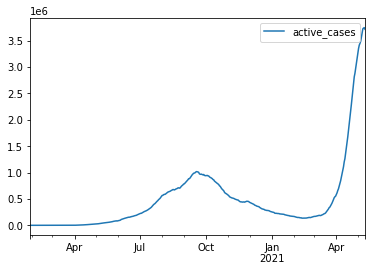

In [131]:
df.plot(y='active_cases')

<AxesSubplot:>

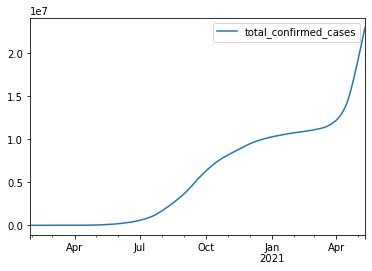

In [118]:
df.plot(y='total_confirmed_cases')

<AxesSubplot:>

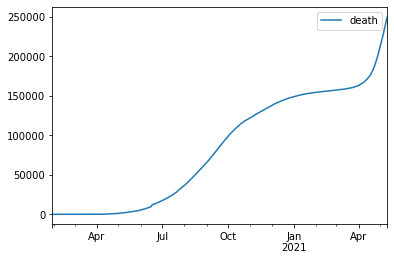

In [119]:
df.plot(y='death')

<AxesSubplot:>

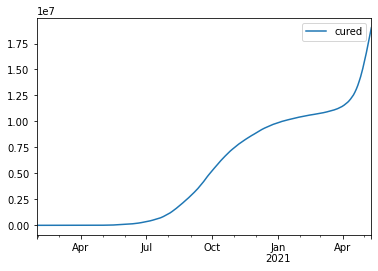

In [120]:
df.plot(y='cured')

We can very clearly see from these plots that cases and deaths have been skyrocketing starting around late March to early April 2021. This is when a new strain of the virus came to India. But what made this new strain so difficult to handle compared to any previous ones, and is the situation different by state in India?

In [132]:
get_json('mohfw.json')

med': 83,
    'death': 3}},
  {'id': '2020-03-31T20:30:00.00+05:30|kl',
   'key': '2020-03-31T20:30:00.00+05:30|kl',
   'value': {'_id': '2020-03-31T20:30:00.00+05:30|kl',
    '_rev': '1-738c6bfe4b3ccc8209aff155455f7246',
    'state': 'kl',
    'type': 'cases',
    'report_time': '2020-03-31T20:30:00.00+05:30',
    'source': 'mohfw',
    'cured': 19,
    'confirmed': 234,
    'death': 1}},
  {'id': '2020-03-31T20:30:00.00+05:30|la',
   'key': '2020-03-31T20:30:00.00+05:30|la',
   'value': {'_id': '2020-03-31T20:30:00.00+05:30|la',
    '_rev': '1-5d4c778dfb1cae0950f075924766c058',
    'state': 'la',
    'type': 'cases',
    'report_time': '2020-03-31T20:30:00.00+05:30',
    'source': 'mohfw',
    'cured': 3,
    'confirmed': 13,
    'death': 0}},
  {'id': '2020-03-31T20:30:00.00+05:30|mh',
   'key': '2020-03-31T20:30:00.00+05:30|mh',
   'value': {'_id': '2020-03-31T20:30:00.00+05:30|mh',
    '_rev': '1-84e5ecdef08bb45e7ac52269bf4fb314',
    'state': 'mh',
    'type': 'cases',
    'repor